# Create Project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"


df = pd.read_excel(FILE, sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Convert to Classification

In [3]:
#set target
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    30.0
1    30.0
2    50.0
3    75.0
4    50.0
Name: G3(%), dtype: float64

In [4]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)

0      F
1      F
2      F
3      C
4      F
      ..
390    F
391    C
392    F
393    F
394    F
Name: G3(%), Length: 395, dtype: category
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

In [5]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,30.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,30.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,50.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,75.0,C
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,50.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,4,4,5,4,11,9,9,9,45.0,F
391,MS,M,17,U,LE3,T,3,1,services,services,...,5,3,4,2,3,14,16,16,80.0,C
392,MS,M,21,R,GT3,T,1,1,other,other,...,3,3,3,3,3,10,8,7,35.0,F
393,MS,M,18,R,LE3,T,3,2,services,other,...,1,3,4,5,0,11,12,10,50.0,F


In [6]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(1)

True     0.668354
False    0.331646
Name: target_F, dtype: float64

# Preprocess the data

In [7]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [8]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000210191EA2E0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000210115F4CA0>)],
                  verbose_feature_names_out=False)

In [9]:
# get feature names
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


### Classification Function

In [10]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    ## training data
    print(f"[i] Training Data:")
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize, 
                                                  cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()
    
    
    print(dashes)
    ## training data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize, 
                                                  cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

# Fit Model

## Random Forest

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       101
        True       1.00      1.00      1.00       195

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



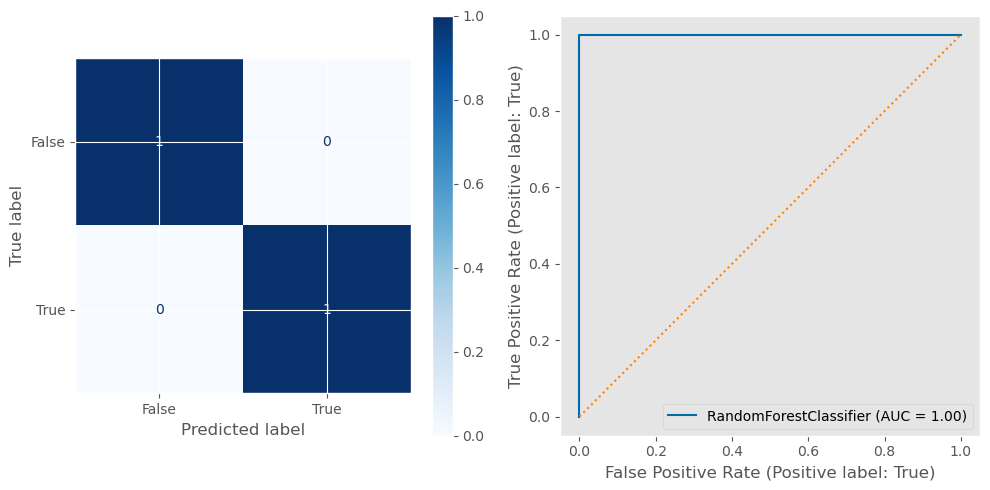

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.77      0.33      0.47        30
        True       0.77      0.96      0.85        69

    accuracy                           0.77        99
   macro avg       0.77      0.64      0.66        99
weighted avg       0.77      0.77      0.73        99



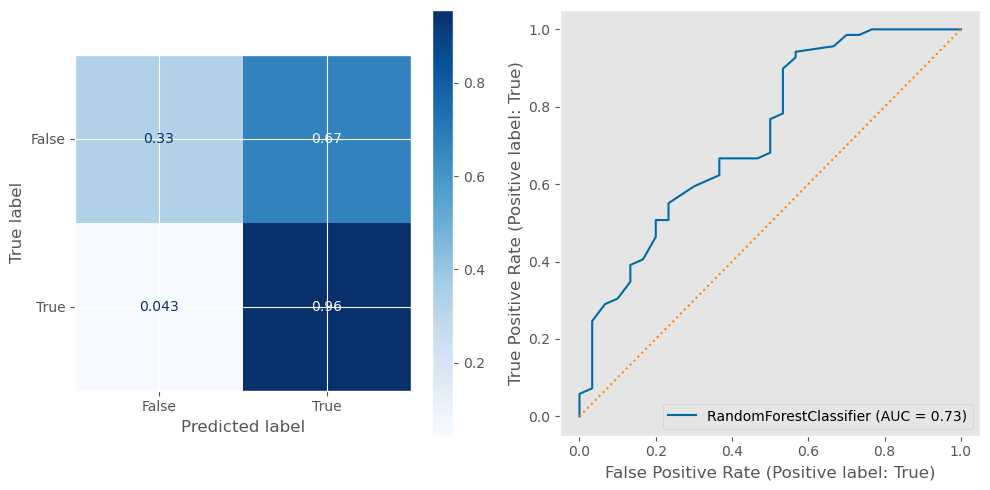

In [11]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

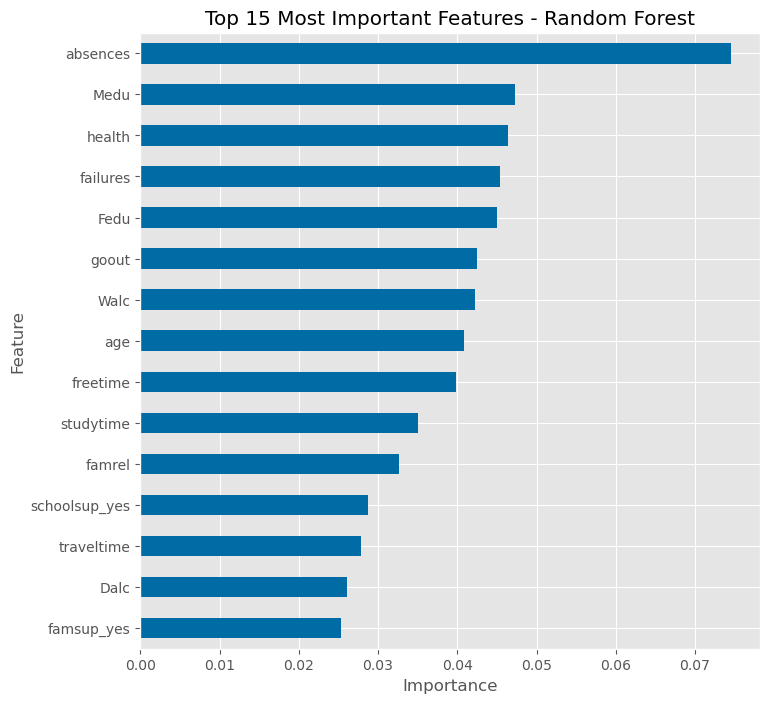

In [12]:
## Saving the feature importances
importances = pd.Series(rf_clf.feature_importances_, index= feature_names,
                       name='RandomForest Feature Importance')
ax = importances.sort_values().tail(15).plot(kind='barh',figsize=(8,8))
ax.set(title='Top 15 Most Important Features - Random Forest',
       ylabel='Feature', xlabel='Importance');

## SHAP

In [13]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [14]:
#fit SHAP
X_shap = shap.sample(X_train_df,nsamples=200,random_state=321)
X_shap

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
355,18.0,3.0,3.0,1.0,2.0,0.0,5.0,3.0,4.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
354,17.0,4.0,3.0,2.0,2.0,0.0,4.0,5.0,5.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
328,17.0,4.0,4.0,1.0,3.0,0.0,5.0,4.0,4.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
231,17.0,2.0,2.0,2.0,2.0,0.0,4.0,5.0,2.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
312,19.0,1.0,2.0,1.0,2.0,1.0,4.0,5.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,19.0,3.0,3.0,1.0,4.0,0.0,4.0,3.0,3.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
236,17.0,2.0,2.0,1.0,2.0,0.0,4.0,4.0,2.0,5.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
10,15.0,4.0,4.0,1.0,2.0,0.0,3.0,3.0,3.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
13,15.0,4.0,3.0,2.0,2.0,0.0,5.0,4.0,3.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [15]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index].astype(int)
y_shap 

355    1
354    1
328    1
231    1
312    1
      ..
210    1
236    0
10     1
13     1
372    1
Name: target_F, Length: 200, dtype: int32

In [16]:
explainer = shap.Explainer(rf_clf)
explainer

In [17]:
## Getting the shap values
shap_values = explainer(X_shap)
shap_values.shape

(200, 43, 2)

In [18]:
shap_vals_F = shap_values[:,:,1]
shap_vals_F.shape

(200, 43)

# Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


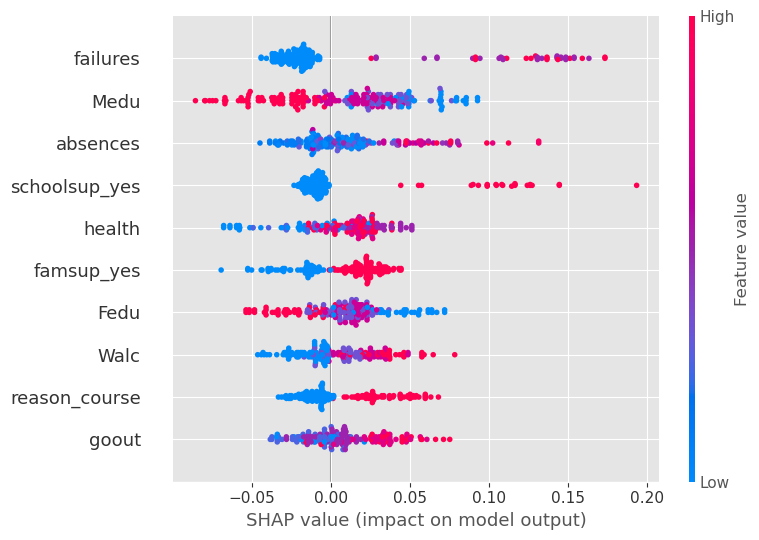

In [19]:
shap.summary_plot(shap_vals_F,max_display=10)


## Summary
#### Top 5 Most Important Features:
- Failures:The more failures the more likely the model will predict a Failing grade.
- Medu:The higher the mother's education level the less likely the model will predict a Failing grade.
- absences:The more absences the more likely the model will predict a Failing grade.
- schoolsup_yes:students who receive additional school support are more likely to be a predicted Failure.
- health:The healthier the student is, the more likely the model will predict a Failing grade.

# Logistic Regression

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.71      0.54      0.61       101
        True       0.79      0.88      0.83       195

    accuracy                           0.77       296
   macro avg       0.75      0.71      0.72       296
weighted avg       0.76      0.77      0.76       296



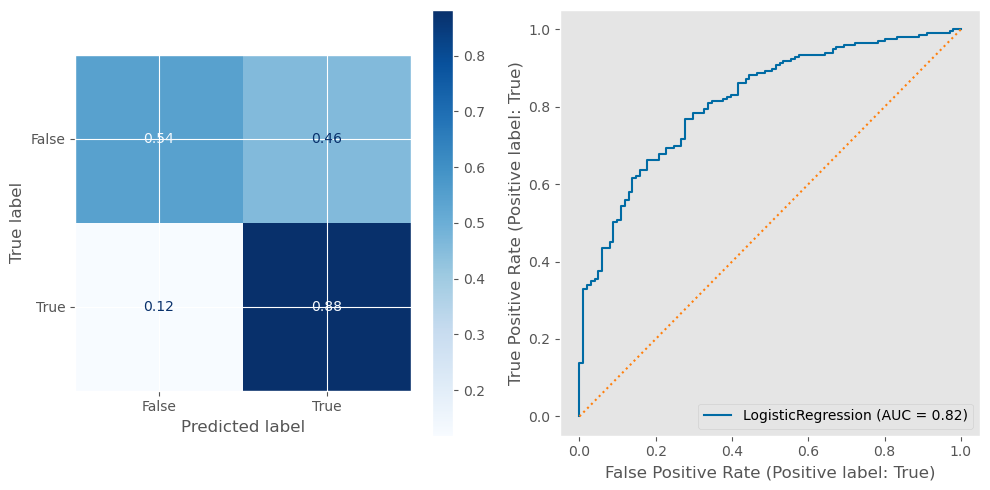

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.52      0.40      0.45        30
        True       0.76      0.84      0.80        69

    accuracy                           0.71        99
   macro avg       0.64      0.62      0.63        99
weighted avg       0.69      0.71      0.69        99



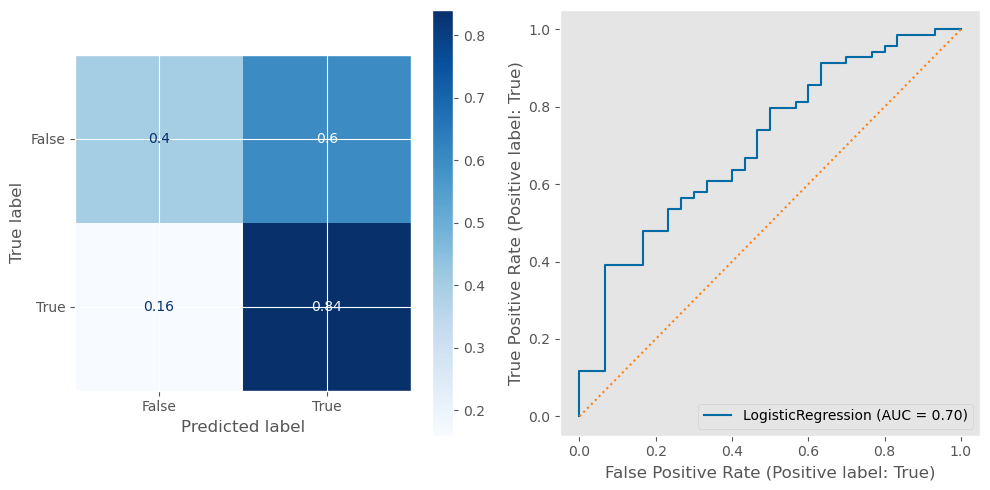

In [20]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)#,class_weight='balanced')
log_reg.fit(X_train_df,y_train)
evaluate_classification(log_reg,X_train_df,y_train, X_test_df,y_test)

In [21]:
explainer = shap.Explainer(log_reg.predict, X_shap)
explainer

In [24]:
## Getting the shap values
shap_values = explainer(X_shap)
shap_values.shape

(200, 43)

## Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


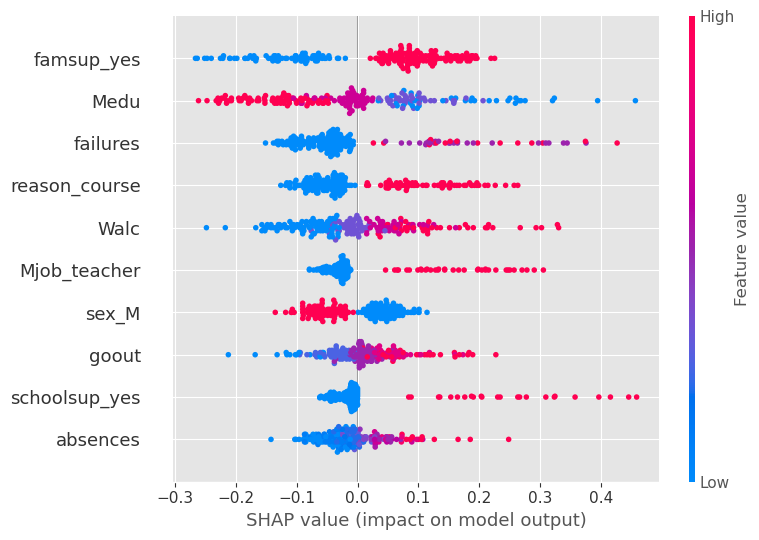

In [25]:
shap.summary_plot(shap_values,max_display=10)

## Summary Top 5 Most Important Features:
- famsup_yes:If the student is receiving supplemental support from their family, they are more likely to be predicted to Fail.

- Medu:The higher the mother's education level the less likely the model will predict a Failing grade.

- failures:The more failures the student had in other courses the more likely the model predicted they would fail math.

- Walc:The greater the weekend alcohol consumption, the more likely the model will predict a Failing grade.

- reason_course:If a student is attending their school for a specific course, they are more likely to be predicted to Fail.